# Análise Exploratória de Dados (EDA)
## Dados Meteorológicos do INMET - Pernambuco

**Objetivo:** Realizar análise exploratória dos dados meteorológicos coletados das estações automáticas do INMET no estado de Pernambuco.

**Foco:** Entender a distribuição dos dados, identificar problemas e preparar para tratamento e modelagem.

---


## 1. Importação de Bibliotecas


In [10]:
import sys
import subprocess

def install_if_missing(package):
    try:
        __import__(package.split('-')[0].split('[')[0])
    except ImportError:
        print(f"Instalando {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])

dependencies = [
    'pandas', 'numpy', 'matplotlib', 'seaborn', 'sqlalchemy', 'psycopg2-binary'
]

for dep in dependencies:
    install_if_missing(dep)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


## 2. Conexão com PostgreSQL


In [11]:
# Configurações de conexão com PostgreSQL
DB_CONFIG = {
    'host': 'postgres',
    'port': 5432,
    'database': 'inmet_db',
    'user': 'inmet_user',
    'password': 'inmet_password'
}

print("Configuração de conexão definida!")


Configuração de conexão definida!


## 3. Carregamento dos Dados


In [12]:
# Query para carregar dados meteorológicos
query = """
SELECT 
    dm.*,
    e.nome as nome_estacao,
    e.uf,
    e.latitude,
    e.longitude
FROM dados_meteorologicos dm
JOIN estacoes e ON dm.codigo_wmo = e.codigo_wmo
ORDER BY dm.timestamp_utc
"""

# Lê dados usando conexão direta com psycopg2 (evita problemas de encoding)
try:
    conn = psycopg2.connect(
        host=DB_CONFIG['host'],
        port=DB_CONFIG['port'],
        database=DB_CONFIG['database'],
        user=DB_CONFIG['user'],
        password=DB_CONFIG['password']
    )
    conn.set_client_encoding('UTF8')
    df = pd.read_sql(query, conn)
    conn.close()
    
    # Converte timestamp
    df['timestamp_utc'] = pd.to_datetime(df['timestamp_utc'])
    
    print("Dados carregados com sucesso!")
except Exception as e:
    print(f"Erro ao carregar dados: {e}")
    df = pd.DataFrame()

print(f"Dados carregados: {len(df):,} registros")

# Verifica se há dados antes de processar
if len(df) == 0:
    print("\nATENÇÃO: Nenhum dado encontrado no banco!")
    print("\nPara carregar dados, execute:")
    print("1. Coloque arquivos CSV em: fastapi/app/data/raw/")
    print("2. Execute: curl -X POST http://localhost:8000/ingest")
    print("3. Execute: curl -X POST http://localhost:8000/load-to-db")
    print("\nOu use a interface do FastAPI em: http://localhost:8000/docs")
else:
    print(f"Período: {df['timestamp_utc'].min()} até {df['timestamp_utc'].max()}")
    print(f"Estações: {df['codigo_wmo'].nunique()} estações únicas")
    print("\nPrimeiras linhas:")
    display(df.head())


Dados carregados com sucesso!
Dados carregados: 192,960 registros
Período: 2024-01-01 00:00:00 até 2025-10-31 23:00:00
Estações: 12 estações únicas

Primeiras linhas:


,id,codigo_wmo,data,hora_utc,timestamp_utc,precipitacao_mm,pressao_estacao_mb,pressao_max_mb,pressao_min_mb,radiacao_global_kjm2,...,umidade_rel_horaria_pct,vento_direcao_graus,vento_rajada_max_ms,vento_velocidade_ms,intensidade_chuva,created_at,nome_estacao,uf,latitude,longitude
0,48388,A309,2024-01-01,00:00:00,2024-01-01,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,NaN,0.0,sem_chuva,2025-12-03 18:35:27.094220,ARCO VERDE,PE,-8.433611,-37.055556
1,180400,A329,2024-01-01,00:00:00,2024-01-01,0.0,974.2,974.3,974.1,NaN,...,69.0,307.0,0.0,0.0,sem_chuva,2025-12-03 18:36:52.118385,CABROBO,PE,-8.503889,-39.315278
2,212560,A349,2024-01-01,00:00:00,2024-01-01,13.2,964.1,NaN,NaN,0.0,...,0.0,250.0,NaN,2.1,forte,2025-12-03 18:37:02.135987,IBIMIRIM,PE,-8.509444,-37.711667
3,80468,A322,2024-01-01,00:00:00,2024-01-01,NaN,922.1,922.1,921.4,NaN,...,NaN,64.0,6.8,3.5,sem_chuva,2025-12-03 18:35:30.314697,GARANHUNS,PE,-8.910833,-36.493333
4,164320,A328,2024-01-01,00:00:00,2024-01-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,sem_chuva,2025-12-03 18:36:46.857178,SURUBIM,PE,-7.842500,-35.790278


## 4. Informações Gerais do Dataset


In [13]:
if len(df) > 0:
    print("=" * 60)
    print("INFORMAÇÕES GERAIS DO DATASET")
    print("=" * 60)
    print(f"\nDimensões: {df.shape[0]:,} linhas x {df.shape[1]} colunas")
    print(f"Número de estações: {df['codigo_wmo'].nunique()}")
    
    if pd.notna(df['timestamp_utc'].min()) and pd.notna(df['timestamp_utc'].max()):
        print(f"Período: {df['timestamp_utc'].min()} até {df['timestamp_utc'].max()}")
        total_dias = (df['timestamp_utc'].max() - df['timestamp_utc'].min()).days
        print(f"Total de dias: {total_dias} dias")
    
    print("\n" + "=" * 60)
    print("ESTAÇÕES METEOROLÓGICAS")
    print("=" * 60)
    estacoes = df.groupby('codigo_wmo').agg({
        'nome_estacao': 'first',
        'uf': 'first',
        'timestamp_utc': ['min', 'max', 'count']
    }).round(2)
    estacoes.columns = ['Estação', 'UF', 'Data Início', 'Data Fim', 'Total Registros']
    display(estacoes)
    
    print("\n" + "=" * 60)
    print("TIPOS DE DADOS")
    print("=" * 60)
    print(df.dtypes)
else:
    print("Nenhum dado disponível para análise!")


INFORMAÇÕES GERAIS DO DATASET

Dimensões: 192,960 linhas x 28 colunas
Número de estações: 12
Período: 2024-01-01 00:00:00 até 2025-10-31 23:00:00
Total de dias: 669 dias

ESTAÇÕES METEOROLÓGICAS


,Estação,UF,Data Início,Data Fim,Total Registros
codigo_wmo,,,,,
A307,PETROLINA,PE,2024-01-01,2025-10-31 23:00:00,16080
A309,ARCO VERDE,PE,2024-01-01,2025-10-31 23:00:00,16080
A322,GARANHUNS,PE,2024-01-01,2025-10-31 23:00:00,16080
A328,SURUBIM,PE,2024-01-01,2025-10-31 23:00:00,16080
A329,CABROBO,PE,2024-01-01,2025-10-31 23:00:00,16080
A341,CARUARU,PE,2024-01-01,2025-10-31 23:00:00,16080
A349,IBIMIRIM,PE,2024-01-01,2025-10-31 23:00:00,16080
A350,SERRA TALHADA,PE,2024-01-01,2025-10-31 23:00:00,16080
A351,FLORESTA,PE,2024-01-01,2025-10-31 23:00:00,16080



TIPOS DE DADOS
id                                    int64
codigo_wmo                           object
data                                 object
hora_utc                             object
timestamp_utc                datetime64[ns]
precipitacao_mm                     float64
pressao_estacao_mb                  float64
pressao_max_mb                      float64
pressao_min_mb                      float64
radiacao_global_kjm2                float64
temperatura_ar_c                    float64
temperatura_orvalho_c               float64
temperatura_max_c                   float64
temperatura_min_c                   float64
temperatura_orvalho_max_c           float64
temperatura_orvalho_min_c           float64
umidade_rel_max_pct                 float64
umidade_rel_min_pct                 float64
umidade_rel_horaria_pct             float64
vento_direcao_graus                 float64
vento_rajada_max_ms                 float64
vento_velocidade_ms                 float64
intensidade_chuv

## 5. Análise de Valores Faltantes


VALORES FALTANTES POR VARIÁVEL


,Variável,Valores Faltantes,Percentual (%)
15,temperatura_orvalho_min_c,131241,68.014614
17,umidade_rel_min_pct,131224,68.005804
14,temperatura_orvalho_max_c,131211,67.999067
16,umidade_rel_max_pct,131184,67.985075
11,temperatura_orvalho_c,130758,67.764303
20,vento_rajada_max_ms,117704,60.999171
12,temperatura_max_c,117638,60.964967
13,temperatura_min_c,117638,60.964967
8,pressao_min_mb,117637,60.964449
7,pressao_max_mb,117637,60.964449


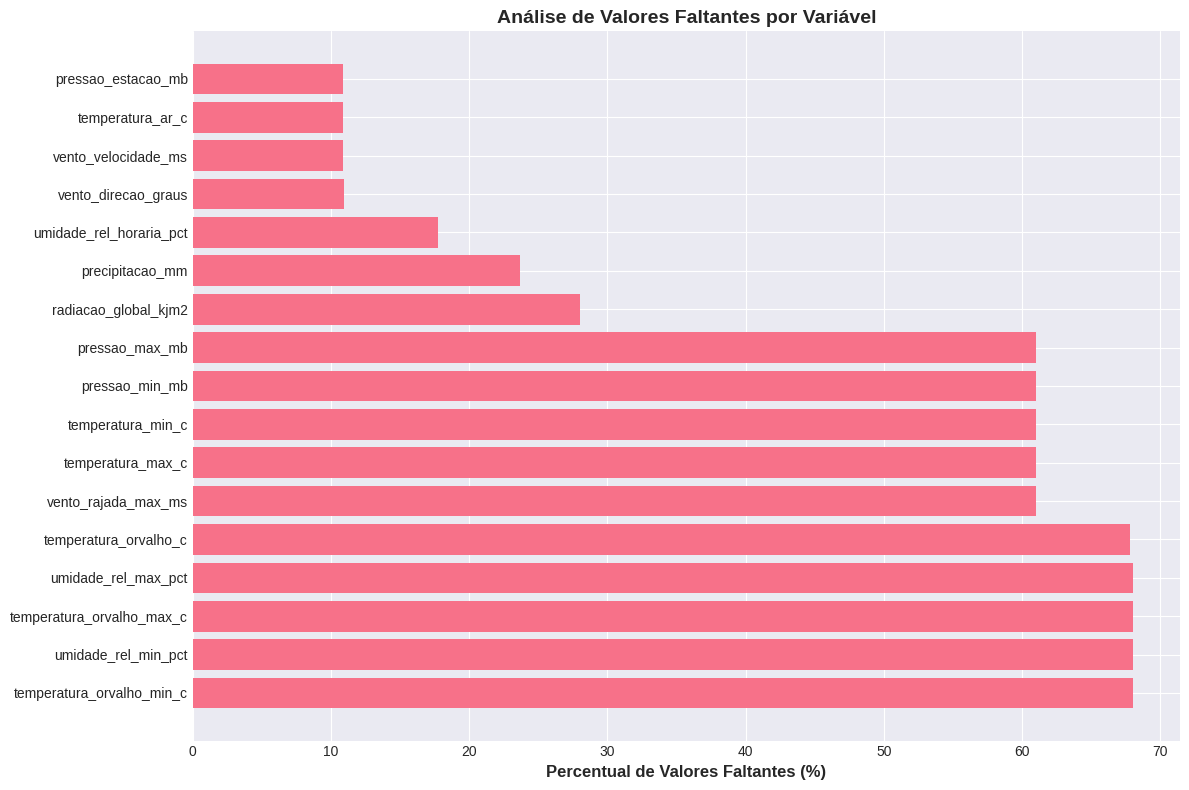

In [14]:
if len(df) > 0:
    # Análise de valores faltantes
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Variável': missing.index,
        'Valores Faltantes': missing.values,
        'Percentual (%)': missing_pct.values
    }).sort_values('Valores Faltantes', ascending=False)
    
    missing_df = missing_df[missing_df['Valores Faltantes'] > 0]
    
    print("=" * 60)
    print("VALORES FALTANTES POR VARIÁVEL")
    print("=" * 60)
    display(missing_df)
    
    # Visualização
    if len(missing_df) > 0:
        plt.figure(figsize=(12, 8))
        plt.barh(missing_df['Variável'], missing_df['Percentual (%)'])
        plt.xlabel('Percentual de Valores Faltantes (%)', fontsize=12, fontweight='bold')
        plt.title('Análise de Valores Faltantes por Variável', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNenhum valor faltante encontrado!")
else:
    print("Nenhum dado disponível para análise!")


## 6. Estatísticas Descritivas


ESTATÍSTICAS DESCRITIVAS


,precipitacao_mm,pressao_estacao_mb,temperatura_ar_c,umidade_rel_horaria_pct,vento_velocidade_ms,radiacao_global_kjm2
count,147271.000000,171985.000000,171984.000000,158687.000000,171947.000000,138897.000000
mean,0.067304,823.230417,21.586138,56.801487,1.939328,868.732801
std,0.667731,333.118339,9.621344,32.238975,1.520574,1145.741225
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,922.700000,20.000000,38.000000,0.500000,0.000000
50%,0.000000,959.900000,23.700000,64.000000,1.900000,91.400000
75%,0.000000,971.700000,27.600000,83.000000,3.100000,1665.200000
max,48.400000,1002.400000,39.400000,100.000000,8.900000,5350.500000


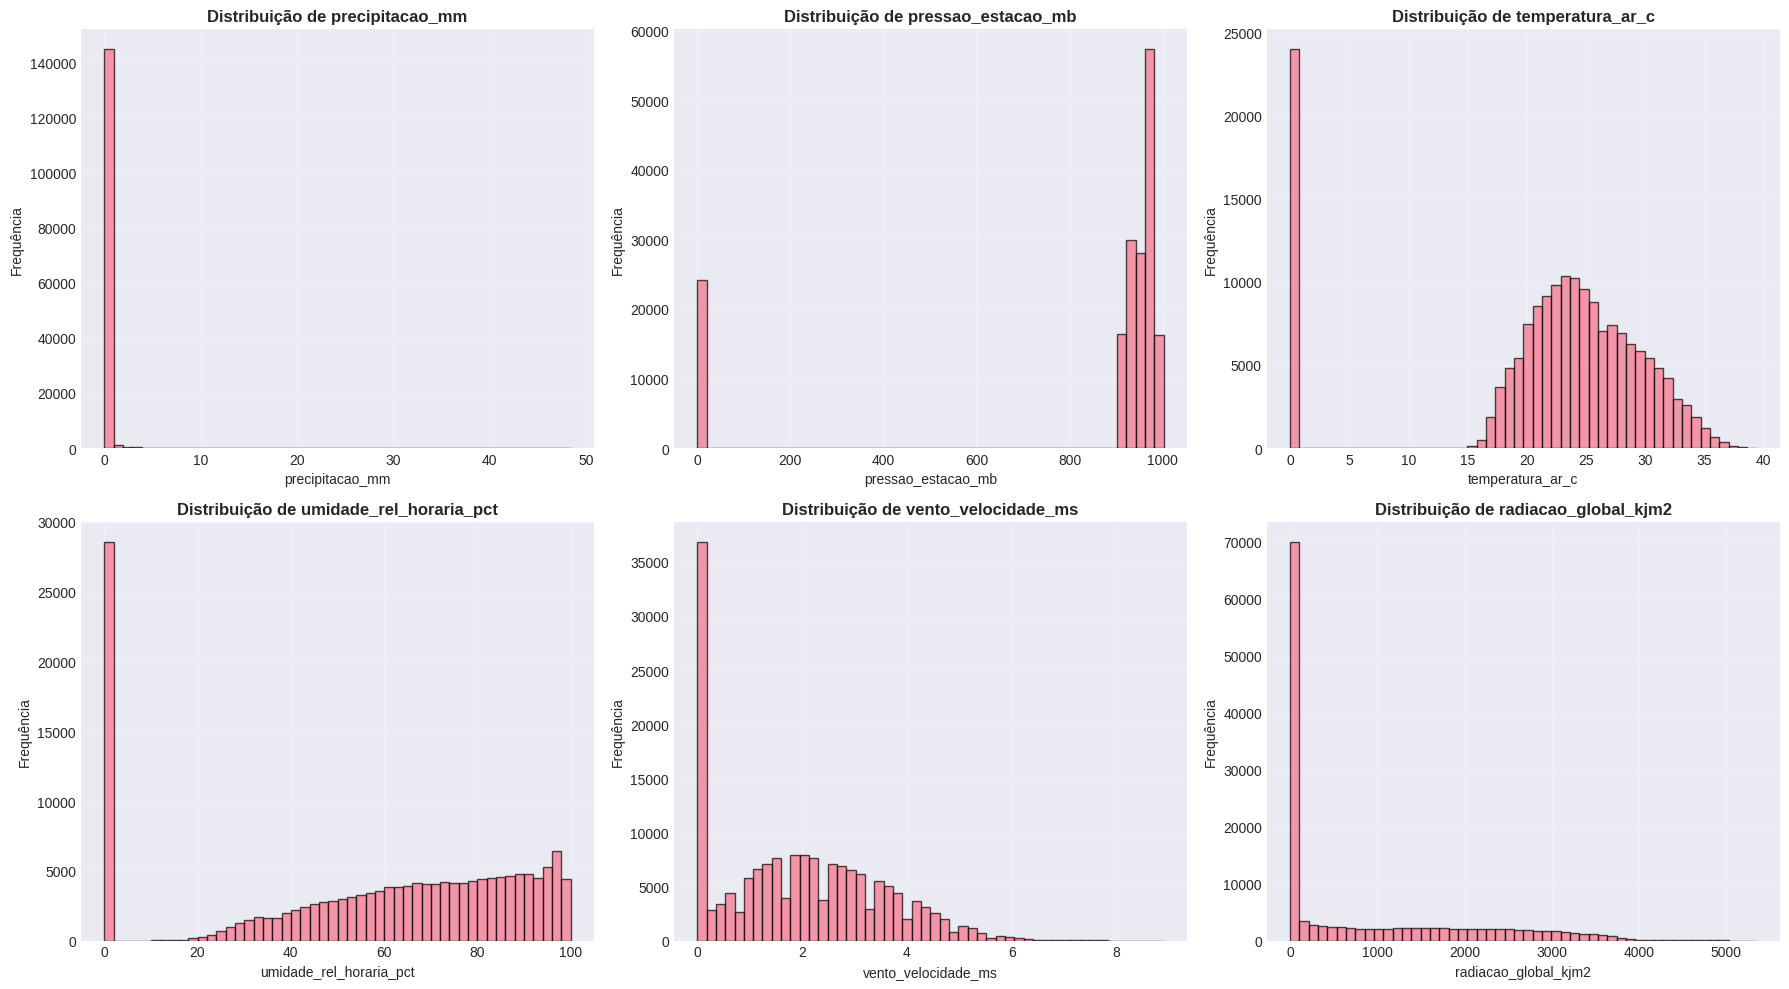

In [15]:
if len(df) > 0:
    # Seleciona variáveis numéricas principais
    vars_numericas = [
        'precipitacao_mm', 'pressao_estacao_mb', 'temperatura_ar_c',
        'umidade_rel_horaria_pct', 'vento_velocidade_ms', 'radiacao_global_kjm2'
    ]
    
    vars_existentes = [v for v in vars_numericas if v in df.columns]
    
    if vars_existentes:
        print("=" * 60)
        print("ESTATÍSTICAS DESCRITIVAS")
        print("=" * 60)
        display(df[vars_existentes].describe())
        
        # Visualização de distribuições
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for i, var in enumerate(vars_existentes[:6]):
            if i < len(axes):
                df[var].hist(bins=50, ax=axes[i], edgecolor='black', alpha=0.7)
                axes[i].set_title(f'Distribuição de {var}', fontweight='bold')
                axes[i].set_xlabel(var)
                axes[i].set_ylabel('Frequência')
                axes[i].grid(alpha=0.3)
        
        # Remove eixos vazios
        for i in range(len(vars_existentes), len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()
    else:
        print("Nenhuma variável numérica encontrada!")
else:
    print("Nenhum dado disponível para análise!")


## 7. Análise de Precipitação (Variável Principal)


ANÁLISE DE PRECIPITAÇÃO

Estatísticas de Precipitação:
  Média: 0.07 mm
  Mediana: 0.00 mm
  Máximo: 48.40 mm
  Mínimo: 0.00 mm
  Desvio Padrão: 0.67 mm

  Valores nulos: 45,689 (23.68%)


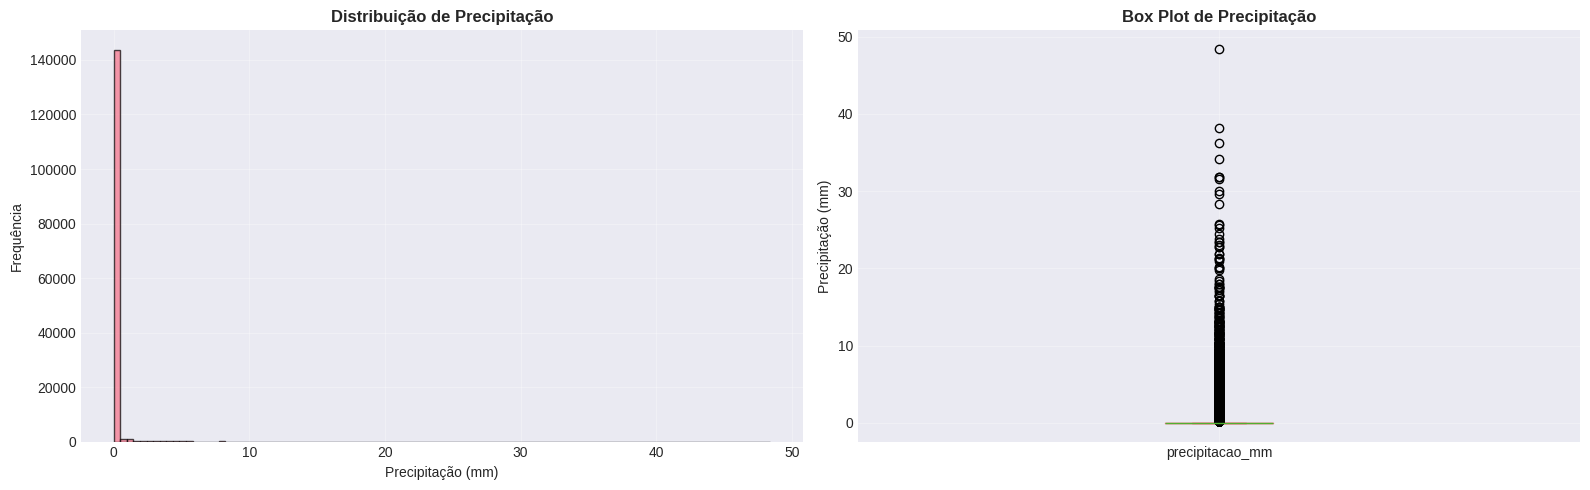

In [16]:
if len(df) > 0 and 'precipitacao_mm' in df.columns:
    print("=" * 60)
    print("ANÁLISE DE PRECIPITAÇÃO")
    print("=" * 60)
    
    # Estatísticas
    print(f"\nEstatísticas de Precipitação:")
    print(f"  Média: {df['precipitacao_mm'].mean():.2f} mm")
    print(f"  Mediana: {df['precipitacao_mm'].median():.2f} mm")
    print(f"  Máximo: {df['precipitacao_mm'].max():.2f} mm")
    print(f"  Mínimo: {df['precipitacao_mm'].min():.2f} mm")
    print(f"  Desvio Padrão: {df['precipitacao_mm'].std():.2f} mm")
    
    # Valores nulos
    nulos = df['precipitacao_mm'].isnull().sum()
    print(f"\n  Valores nulos: {nulos:,} ({nulos/len(df)*100:.2f}%)")
    
    # Visualização
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Histograma
    df['precipitacao_mm'].hist(bins=100, ax=axes[0], edgecolor='black', alpha=0.7)
    axes[0].set_title('Distribuição de Precipitação', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Precipitação (mm)')
    axes[0].set_ylabel('Frequência')
    axes[0].grid(alpha=0.3)
    
    # Box plot
    df['precipitacao_mm'].plot(kind='box', ax=axes[1], vert=True)
    axes[1].set_title('Box Plot de Precipitação', fontweight='bold', fontsize=12)
    axes[1].set_ylabel('Precipitação (mm)')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Dados de precipitação não disponíveis!")


## 8. Análise Temporal


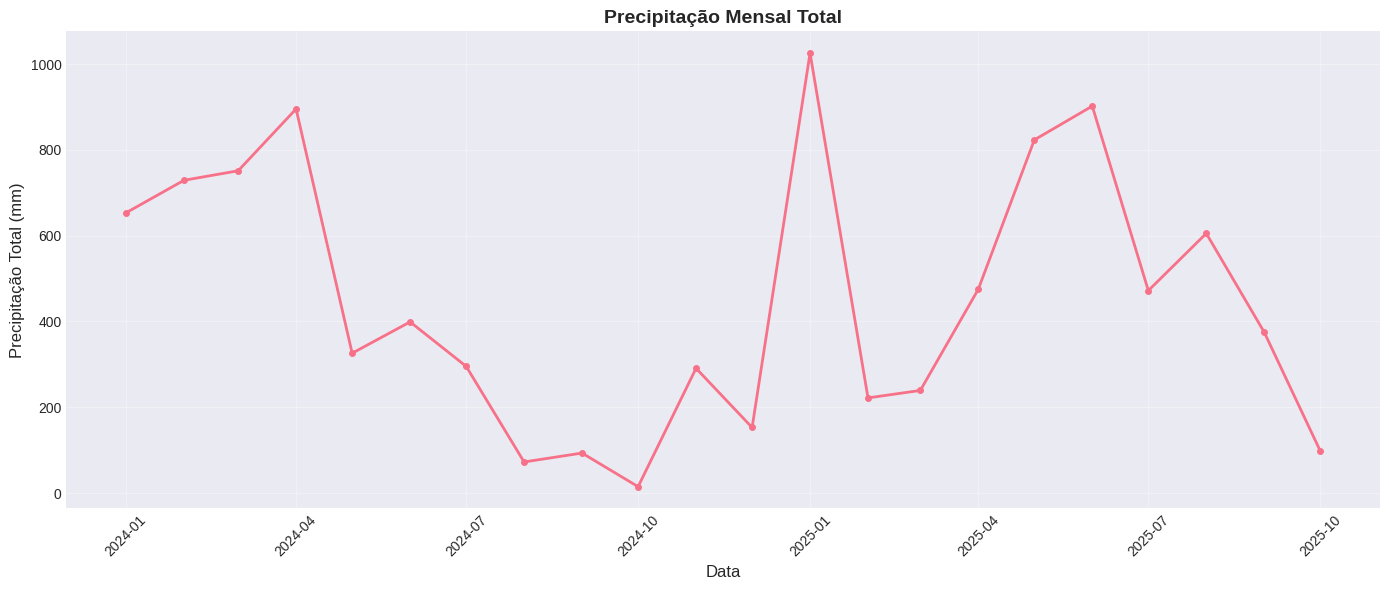


Precipitação por Mês:


,ano,mes,precipitacao_mm,data
0,2024,1,653.4,2024-01-01
1,2024,2,729.2,2024-02-01
2,2024,3,751.4,2024-03-01
3,2024,4,895.6,2024-04-01
4,2024,5,326.0,2024-05-01
5,2024,6,399.0,2024-06-01
6,2024,7,295.4,2024-07-01
7,2024,8,72.4,2024-08-01
8,2024,9,93.2,2024-09-01
9,2024,10,14.8,2024-10-01


In [17]:
if len(df) > 0 and 'timestamp_utc' in df.columns:
    # Extrai componentes temporais
    df['ano'] = df['timestamp_utc'].dt.year
    df['mes'] = df['timestamp_utc'].dt.month
    df['dia'] = df['timestamp_utc'].dt.day
    df['hora'] = df['timestamp_utc'].dt.hour
    
    # Agregação mensal de precipitação
    if 'precipitacao_mm' in df.columns:
        df_mensal = df.groupby(['ano', 'mes']).agg({
            'precipitacao_mm': 'sum'
        }).reset_index()
        
        # Cria data a partir de ano e mês (corrigido)
        df_mensal['data'] = pd.to_datetime({
            'year': df_mensal['ano'],
            'month': df_mensal['mes'],
            'day': 1
        })
        
        # Visualização
        plt.figure(figsize=(14, 6))
        plt.plot(df_mensal['data'], df_mensal['precipitacao_mm'], marker='o', linewidth=2, markersize=4)
        plt.title('Precipitação Mensal Total', fontsize=14, fontweight='bold')
        plt.xlabel('Data', fontsize=12)
        plt.ylabel('Precipitação Total (mm)', fontsize=12)
        plt.grid(alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        print("\nPrecipitação por Mês:")
        display(df_mensal)
else:
    print("Dados temporais não disponíveis!")


## 9. Resumo da Análise Exploratória


In [18]:
print("=" * 80)
print("RESUMO DA ANÁLISE EXPLORATÓRIA")
print("=" * 80)

if len(df) > 0:
    print(f"\nDataset carregado com sucesso!")
    print(f"   - Total de registros: {len(df):,}")
    print(f"   - Número de estações: {df['codigo_wmo'].nunique()}")
    print(f"   - Período: {df['timestamp_utc'].min()} até {df['timestamp_utc'].max()}")
    
    print(f"\nPróximos passos:")
    print(f"   1. Executar notebook 02_tratamento_limpeza.ipynb")
    print(f"   2. Tratar valores faltantes")
    print(f"   3. Classificar intensidade de chuva")
    print(f"   4. Preparar dados para modelagem")
else:
    print("\nNenhum dado disponível!")
    print("   Execute a ingestão de dados primeiro.")

print("\n" + "=" * 80)


RESUMO DA ANÁLISE EXPLORATÓRIA

Dataset carregado com sucesso!
   - Total de registros: 192,960
   - Número de estações: 12
   - Período: 2024-01-01 00:00:00 até 2025-10-31 23:00:00

Próximos passos:
   1. Executar notebook 02_tratamento_limpeza.ipynb
   2. Tratar valores faltantes
   3. Classificar intensidade de chuva
   4. Preparar dados para modelagem

